In [2]:
import sys
sys.executable

'/Users/b/ml/seq2seq/venv/bin/python'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
#import torchtext
import tqdm
import evaluate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [5]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
dataset = datasets.load_dataset("bentrevett/multi30k")
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"], 
    dataset["test"],
)

In [7]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [8]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
        en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])]
        de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])]
        if lower:
            en_tokens = [token.lower() for token in en_tokens]
            de_tokens = [token.lower() for token in de_tokens]

        en_tokens = [sos_token] + en_tokens + [eos_token]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        return {"en_tokens": en_tokens, "de_tokens": de_tokens}
    

In [9]:
max_length = 1000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)


Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
# build Vocab class
# build build vocab from iterator
from collections import Counter, defaultdict

class Vocab: 
    def __init__(self, token_to_index, unk_token="<unk>"):
        self.token_to_index = token_to_index
        self.index_to_token = {idx: token for token, idx in token_to_index.items()}
        self.unk_token = unk_token
        self.unk_index = token_to_index[unk_token]

    def __len__(self):
        return len(self.token_to_index)

    def __getitem__(self, token):
        return self.token_to_index.get(token, self.unk_index)

    def token_to_idx(self, token):
        return self.__getitem__(token)

    def idx_to_token(self, idx):
        return self.index_to_token.get(idx, self.unk_index)

    def get_itos(self):
        """ returns the index-to-string mapping (i.e., list of token)."""
        # creating a list with tokens where the index corresponds to the token's position
        max_index = max(self.index_to_token.keys())
        itos = [self.index_to_token.get(i, self.unk_token) for i in range(max_index + 1)]
        return itos

    def get_stoi(self):
        """returns the string-to-index mapping (dictionary of tokensd and their indices"""
        return self.token_to_index

    def set_default_index(self, index):
        """sets the default index for unkown tokens."""
        self.unk_index = index

    def lookup_indices(self, tokens):
        """ returns a list of the indices for the given list of tokens."""
        return [self.token_to_idx(token) for token in tokens]

    def lookup_tokens(self, indices):
        """ returns a list of tokens for the given list of indices."""
        if torch.is_tensor(indices):
            indices = indices.tolist()

        return [self.idx_to_token(index) for index in indices]


def build_vocab_from_iterator(iterator, min_freq=1, specials=None):
    """
    Builds a vocabulary from an iterator

    Args:
    - iterator (iterable): an iterable yielding lists of tokens.
    - min_freq (int): the minimum frequency a token must have to be included in the vocabulary
    - specials (list): a list of special tokens (e.g., ['<unk>', '<pad>', ...])

    Returns:
    - vocab (Vocab): a custom Vocab object containing the token-to-index mapping
    """
    counter = Counter()

    # count frequnecies of tokens in the iterator
    for tokens in iterator:
        counter.update(tokens)

    # start with special tokens
    token_to_index = {}
    if specials:
        for idx, token in enumerate(specials):
            token_to_index[token] = idx

    # add regular tokens to the vocab if they meet the min_freq
    for token, freq in counter.items():
        if freq >= min_freq and token not in token_to_index:
            token_to_index[token] = len(token_to_index)

    # set the <unk> token index if it is not already set
    unk_token = specials[0] if specials else "<unk>"
    if unk_token not in token_to_index:
        token_to_index[unk_token] = len(token_to_index)

    return Vocab(token_to_index, unk_token=unk_token)

tokens = [["i", "love", "pizza"], ["i", "hate", "music", "videos"]]
specials = ["<unk>", "<pad>", "<sos>", "<eos>"]
vocab = build_vocab_from_iterator(tokens, min_freq=1, specials=specials)
print(vocab.token_to_index)
print(vocab.idx_to_token(6))


{'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, 'i': 4, 'love': 5, 'pizza': 6, 'hate': 7, 'music': 8, 'videos': 9}
pizza


In [11]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"], 
    min_freq=min_freq, 
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)



In [12]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [13]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

In [14]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [15]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)


Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)


In [17]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn



In [18]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader
    

In [19]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


In [20]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded) # what does this step do? 
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        # hidden [-2, :, :] is the last of the forwards RNN
        # hidden [-1, :, :] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        # outputs = [src length, batch_size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden


        

In [21]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)


In [25]:
class Decoder(nn.Module):
    def __init__(
        self, 
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch_size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)




        

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch_size]
        # teacher_forcing_ratio is the probabiltiy to use teacher_forcing
        # e.g. if teacher_forcing ratio is 0.75 we use teach forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> token
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embeddign, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest prediction token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs
            
        

In [27]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)


In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 20,518,405 trainable parameters


In [30]:
optimizer = optim.Adam(model.parameters())

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [36]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)



In [37]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) # turn off teacher forcing
            # output = [trg_length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss +=  loss.item()
    return epoch_loss / len(data_loader)





In [38]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut3-model.pt")

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")



  0%|                                                    | 0/10 [00:00<?, ?it/s]/var/folders/p3/rmn1ccsx70g1x47kqmcl76dm0000gn/T/ipykernel_3994/2856839612.py:21: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip)
 10%|████                                     | 1/10 [08:06<1:12:59, 486.56s/it]

	Train Loss:   5.023 | Train PPL: 151.891
	Valid Loss:   4.760 | Valid PPL: 116.698


 20%|████████▏                                | 2/10 [27:26<1:57:42, 882.79s/it]

	Train Loss:   4.141 | Train PPL:  62.886
	Valid Loss:   4.355 | Valid PPL:  77.843


 30%|████████████▎                            | 3/10 [35:10<1:20:40, 691.51s/it]

	Train Loss:   3.474 | Train PPL:  32.275
	Valid Loss:   3.777 | Valid PPL:  43.681


 40%|████████████████▍                        | 4/10 [42:57<1:00:17, 602.94s/it]

	Train Loss:   2.927 | Train PPL:  18.669
	Valid Loss:   3.432 | Valid PPL:  30.949


 50%|█████████████████████▌                     | 5/10 [50:51<46:22, 556.49s/it]

	Train Loss:   2.528 | Train PPL:  12.533
	Valid Loss:   3.294 | Valid PPL:  26.944


 60%|█████████████████████████▊                 | 6/10 [58:40<35:05, 526.45s/it]

	Train Loss:   2.231 | Train PPL:   9.310
	Valid Loss:   3.256 | Valid PPL:  25.947


 70%|██████████████████████████▌           | 7/10 [1:52:12<1:10:14, 1404.73s/it]

	Train Loss:   1.999 | Train PPL:   7.382
	Valid Loss:   3.221 | Valid PPL:  25.063


 80%|████████████████████████████████        | 8/10 [2:00:08<36:57, 1108.82s/it]

	Train Loss:   1.782 | Train PPL:   5.944
	Valid Loss:   3.294 | Valid PPL:  26.948


 90%|████████████████████████████████████▉    | 9/10 [2:07:55<15:08, 908.19s/it]

	Train Loss:   1.621 | Train PPL:   5.059
	Valid Loss:   3.337 | Valid PPL:  28.144


100%|████████████████████████████████████████| 10/10 [2:30:15<00:00, 901.52s/it]

	Train Loss:   1.487 | Train PPL:   4.426
	Valid Loss:   3.385 | Valid PPL:  29.529


In [39]:
model.load_state_dict(torch.load("tut3-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

/var/folders/p3/rmn1ccsx70g1x47kqmcl76dm0000gn/T/ipykernel_3994/330183424.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("tut3-model.pt

| Test Loss: 3.201 | Test PPL:  24.548 |


In [47]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else: 
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
            en_tokens = en_vocab.lookup_tokens(inputs)

    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

In [54]:
def plot_attention(sentence, translations, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translations[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()



In [55]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [56]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)


In [57]:
translation

['<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat',
 ',',
 'something',
 'something',
 '.']

In [58]:
sentence_tokens

['<sos>',
 'ein',
 'mann',
 'mit',
 'einem',
 'orangefarbenen',
 'hut',
 ',',
 'der',
 'etwas',
 'anstarrt',
 '.',
 '<eos>']

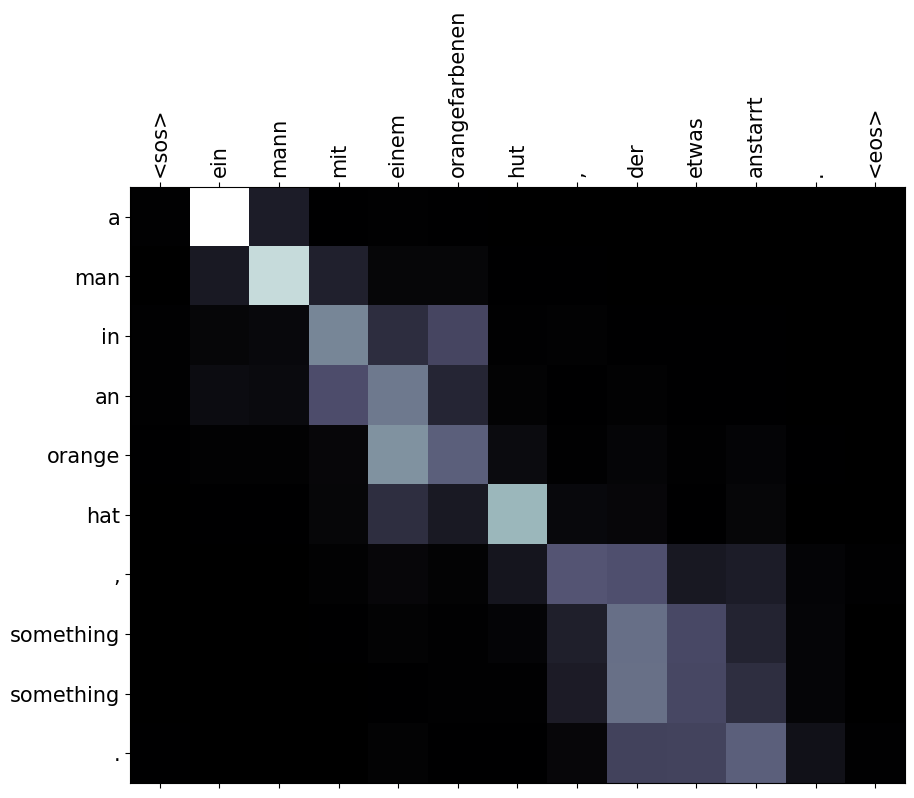

In [59]:
plot_attention(sentence_tokens, translation, attention)

In [60]:
sentence = "Ein Mann sieht sich einen Film an."

In [61]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model, en_nlp, de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [62]:
translation

['<sos>', 'a', 'man', 'watches', 'a', 'a', 'video', '.']

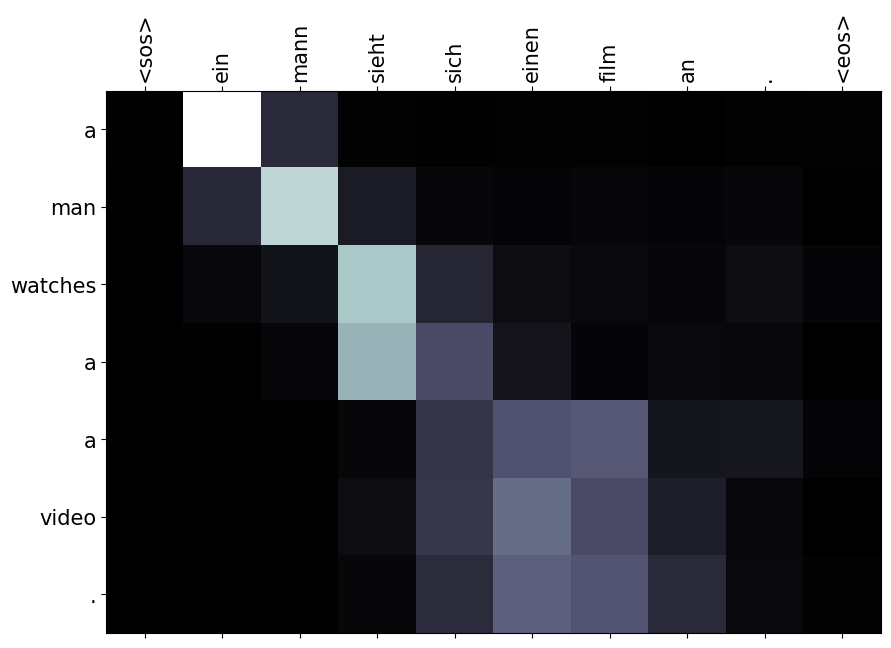

In [63]:
plot_attention(sentence_tokens, translation, attention)

In [64]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )[0]
    for example in tqdm.tqdm(test_data)
]


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.59it/s]


In [65]:
bleu = evaluate.load("bleu")

In [66]:
predictions = [" ".join(translation[1:-1]) for translation in translations]
references = [[example["en"]] for example in test_data]

In [67]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens
    return tokenizer_fn

In [68]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [69]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [70]:
results

{'bleu': 0.2734551180392255,
 'precisions': [0.5881551530694021,
  0.36295521867921243,
  0.222466119488452,
  0.14180206794682423],
 'brevity_penalty': 0.9545819261835495,
 'length_ratio': 0.9555827844999234,
 'translation_length': 12478,
 'reference_length': 13058}